# Summerschool: Social Data Science - Exam Project
## Project: The Trump Twitter Effect
### Group 17. Exam Numbers: 41, 96, 127, 220

*This project studies whether Donald Trump’s sentiment can be used to predict the stock market movements. We conduct a sentiment analysis of his tweets, and uses upervised machine learning to try to predict the Dow Jones stock movement based on his sentiment.*

We start by importing our data source to Python. The file `tweets.json` is created from [the Trump twitter archive](http://www.trumptwitterarchive.com/archive). We have selected all tweets since formal announcement of candidacy.

**DOCSTRING**

Below we provide our docstring to the data project. 
We import the relevant packages, some of which will require installation through either `pip install` or `conda install`. 

In [230]:
'''
DOCSTRING:
Last updated: August 30th 2019.

This project analyzes Donald J. Trump's twitter data and presents a visual analysis of key elements.
It makes use of several packages, some of which should be installed via either pip or conda.
Executing the code cells will save files to the relative path of this Jupyter Notebook. 

'''
## Importing packages
import pandas as pd
import scraping_class, time, json, codecs
import seaborn as sns
import numpy as np
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from afinn import Afinn
from fredapi import Fred
from tqdm import tqdm
from math import sqrt
import statsmodels.api as sm
from matplotlib import pyplot
# Fuzzy
import bs4 as bs
import pickle
import requests
import fuzzywuzzy
# Machine learning
import sklearn
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve, validation_curve, TimeSeriesSplit, train_test_split
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
% matplotlib inline

**Sentiment analyzer**

We have to sentiment analyzers: AFINN and VADER. We define functions for both in the following.
Recall that AFINN ranks the sentence from -5 to 5 and VADER from -1 to 1. 

In [199]:
# Define sentiment analyzer score

# VADER
def sentiment_analyzer_scores(sentence):
    analyser = SentimentIntensityAnalyzer()
    score = analyser.polarity_scores(sentence)
    return score

# AFINN
def afinn_sentiment_analyzer_scores(sentence):
    afinn = Afinn(language='en')
    score = afinn.score(sentence)
    return score

sentence_1 = 'I do love ice cream'
sentence_2 = 'I do not love ice cream'
print('', sentence_1, 'has an AFINN sentiment of', afinn_sentiment_analyzer_scores(sentence_1), '\n',                                                                   
sentence_1, 'has a VADER sentiment of', sentiment_analyzer_scores(sentence_1)['compound'], '\n',
sentence_2, 'has an AFINN sentiment of', afinn_sentiment_analyzer_scores(sentence_2), '\n',
sentence_2, 'has a VADER sentiment of', sentiment_analyzer_scores(sentence_2)['compound'])

 I do love ice cream has an AFINN sentiment of 3.0 
 I do love ice cream has a VADER sentiment of 0.6369 
 I do not love ice cream has an AFINN sentiment of 3.0 
 I do not love ice cream has a VADER sentiment of -0.5216


Based on the results, we see that AFINN is not able to account for the negation, we therefore our analysis continue using only VADER.

### Collecting data

**Trump's tweets**

We set up our connector to the relevant data source and log our connections in a file called *my_log*. 
We later use the log file to visualize our data connection attempts. Next, we scrape the **Trump Twitter Archive** for all tweets from the *@realdonaldtrump* Twitter account.

In [200]:
logfile = 'my_log'## name your log file.
connector = scraping_class.Connector(logfile)
data = []

# Fetching data
for i in range(2015,2020):
    url = 'http://www.trumptwitterarchive.com/data/realdonaldtrump/'+str(i)+'.json'
    r, call_id = connector.get(url, 'Tweets')
    json_file = r.json() 
    data += json_file[::-1] # invert list
    time.sleep(0.5) # set sleep timer to prevent unintentional DOS attacks

**Bloomberg filtered tweets**

Next, we try to collect President Donald Trump's tweets that are relevant to the economy. Bloomberg has already collected these tweets [here](https://www.bloomberg.com/features/trump-tweets-market/).
When trying to fetch the `json` data, we are blocked by Bloomberg. We therefore reside to manually downloading the json text from the `url` and save it into a file called `bloomberg.json`.

In [201]:
# Bloomberg filtered tweets
url = 'https://www.bloomberg.com/bbg-gfx/trump-market-tweets-vs-dow/main.json' # json format
r, call_id = connector.get(url, 'Bloomberg - Tweets')
# json_file = r.json() 
# df_bloom = pd.read_json(json_file)
r.text[:500]

'<!doctype html>\n<html>\n<head>\n    <title>Bloomberg - Are you a robot?</title>\n    <meta name="viewport" content="width=device-width, initial-scale=1">\n    <link rel="stylesheet" type="text/css" href="https://assets.bwbx.io/font-service/css/BWHaasGrotesk-55Roman-Web,BWHaasGrotesk-75Bold-Web,BW%20Haas%20Text%20Mono%20A-55%20Roman/font-face.css">\n    <style rel="stylesheet" type="text/css">\n        html, body, div, span, applet, object, iframe,\n        h1, h2, h3, h4, h5, h6, p, blockquote, pre,\n  '

In [202]:
# load the json file using utf-8 encoding
data_bloom = json.load(codecs.open('bloomberg.json', 'r', 'utf-8-sig'))

**Alpha vantage**

Collecting stock data from the Dow Jones Industrial Average index and S&P 500 using the **Alpha vantage API**.

In [227]:
# Converting the response to datetime
def convert_response(d):
    for dt, prec in d['Time Series (Daily)'].items():
        r = {'datetime':dt}
        r.update(prec)
        yield r

# Looping through DJI and S&P500
indices = {'^DJI':'dji_data_collection','SPX':'sp_data_collection'}
counter = 0
for i,j in indices.items():
    url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol="+i+"&outputsize=full&apikey="
    apikey = "MLOQGMGQHPDJYBVC"
    r, call_id = connector.get(url+apikey, j) #ask for help regarding connector
    if counter == 0:
        data_dji = r.json()
    else:
        data_sp =  r.json()
    counter += 1
    time.sleep(0.5)

Defining the function:

In [204]:
# Connecting to the Alpha Vantage API and fetching data
def AlphaVantage(data):
    df = pd.DataFrame(convert_response(data))
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime',inplace=True)
    df.sort_index(inplace=True)

    #change the name
    df = df.rename(columns={ '1. open':'open','2. high':'high','3. low':'Low','4. close':'close','5. adjusted close':'adj_close','6. volume':'volume','7. dividend amount':'Dividend amount','8. split coefficient':'Split coefficient'})

    df_data = df.iloc[:,[0,3,4,5]] #Select only the columns we want


    df_data['pct_change'] = '' #create empty column to contain pct. change
    r = df_data['adj_close'].astype(float).pct_change(1) #calculate the change
    df_data['pct_change'] = r #store the results in the empty column. There should be one row without a value
    # but fortunately that row is outside of our selected window

    df_data['bool'] = ''

    def pct_bool(df):
        df_pct_bool = []

        for x in df['pct_change']:
            if x > 0:
                df_pct_bool.append(1)
            else:
                df_pct_bool.append(0)

        df["bool"] = df_pct_bool

    pct_bool(df_data)

    df_data_final = df_data.copy()
    

    start_date = '2015-01-01'
    end_date = '2019-08-27'
    df_data_final = df_data[start_date:end_date]
    
    for i in df_data_final.columns:
        df_data_final[i] = df_data_final[i].astype(float)
    
    #df_dji_final.to_csv(data+'.csv') # Save file to CSV
    return df_data_final

### Data frames

Based on the scraped tweets, we set up our initial data frame. We convert the `datetime` to a readable format including timestamp and index by date. We also remove retweets from our data frame.

**Trump Twitter Archive**

In [205]:
### Creating and manipulating dataframes
# Main dataframe
df = pd.DataFrame(data)
date = [i[2]+i[1]+i[-1]+'-'+i[3] for i in df['created_at'].str.split(' ')] # slice date
df['datetime'] = date
df['datetime'] = pd.to_datetime(df['datetime'], format='%d%b%Y-%H:%M:%S') # format datetime 
#df = df[(df['datetime'] > '2017-01-20')] # filter by relevant date
df = df.query("is_retweet == False") # drop retweets
df = df.reset_index(drop=True).sort_values(by=['datetime']) # set index to date
df.index = df['datetime']
display(df.head())
print('Since', df.index[0], 'Mr. Trump has made', len(df), 'tweets') # print number of tweets

,created_at,favorite_count,id_str,in_reply_to_user_id_str,is_retweet,retweet_count,source,text,datetime
datetime,,,,,,,,,
2015-01-01 00:00:26,Thu Jan 01 00:00:26 +0000 2015,33,550441381253382144,None,False,12,Twitter for Android,"""@JaayZen: @realDonaldTrump Thanks Donald. Now...",2015-01-01 00:00:26
2015-01-01 00:02:37,Thu Jan 01 00:02:37 +0000 2015,28,550441927964106753,None,False,9,Twitter for Android,"""@teamconquerca: First time in the""Trump Inter...",2015-01-01 00:02:37
2015-01-01 00:06:40,Thu Jan 01 00:06:40 +0000 2015,36,550442948375347200,None,False,15,Twitter for Android,"""@AngelaTN777: @gochico @realDonaldTrump: He S...",2015-01-01 00:06:40
2015-01-01 00:09:01,Thu Jan 01 00:09:01 +0000 2015,18,550443540111962113,None,False,11,Twitter for Android,"""@JaayZen: @grandmiapens He has all the ingred...",2015-01-01 00:09:01
2015-01-01 00:09:47,Thu Jan 01 00:09:47 +0000 2015,17,550443735054839808,None,False,7,Twitter for Android,"""@MarcAardvark: @realDonaldTrump @ronmeier123 ...",2015-01-01 00:09:47


Since 2015-01-01 00:00:26 Mr. Trump has made 19673 tweets


**Trump tweets - Bloomberg**

In [206]:
# Tweets related to the economy
df_bloom = pd.DataFrame(data_bloom) # load data frame
df_bloom = df_bloom.sort_values(by='timestamp') # chronological order since inception
df_bloom['firstdifference'] = df_bloom['dow'] - df_bloom['dow'].shift() # first DJIA change since last row
df_bloom['relativechange'] = (df_bloom['dow'] - df_bloom['dow'].shift())/df_bloom['dow']*100 # relative change
df_bloom['sentiment'] = [sentiment_analyzer_scores(tweet)['compound'] for tweet in df_bloom['text']] # sentiment (VADER)
date = [i[0]+'-'+i[1][:8] for i in df_bloom['timestamp'].str.split('T')] # slice date
df_bloom['datetime'] = date
df_bloom['datetime'] = pd.to_datetime(df_bloom['datetime'], format='%Y-%m-%d-%H:%M:%S') # format datetime 
df_bloom['datetime']
df_bloom.index = df_bloom['datetime']
display(df_bloom.head())

,dow,id,id_int,text,timestamp,firstdifference,relativechange,sentiment,datetime
datetime,,,,,,,,,
2017-01-20 17:54:36,19827.2500,822502601304526848,822502601304526800,We will bring back our jobs. We will bring bac...,2017-01-20T17:54:36.000Z,NaN,NaN,0.7345,2017-01-20 17:54:36
2017-01-23 11:38:16,19799.8496,823495059010109440,823495059010109400,Busy week planned with a heavy focus on jobs a...,2017-01-23T11:38:16.000Z,-27.4004,-0.138387,0.4939,2017-01-23 11:38:16
2017-01-24 11:11:47,19912.7109,823850781946343427,823850781946343400,Will be meeting at 9:00 with top automobile ex...,2017-01-24T11:11:47.000Z,112.8613,0.566780,0.3382,2017-01-24 11:11:47
2017-01-26 13:55:03,20100.9102,824616644370714627,824616644370714600,of jobs and companies lost. If Mexico is unwil...,2017-01-26T13:55:03.000Z,188.1993,0.936273,-0.5994,2017-01-26 13:55:03
2017-01-30 14:23:49,19971.1309,826073437735100418,826073437735100400,Where was all the outrage from Democrats and t...,2017-01-30T14:23:49.000Z,-129.7793,-0.649835,-0.1531,2017-01-30 14:23:49


**Sentiment analyzer**

Next, we run the sentiment analyzers on our data frame. As there are a lot of tweets this process is quite time consuming.

In [207]:
# Add sentiment to dataframe
df['sentiment'] = [sentiment_analyzer_scores(tweet)['compound'] for tweet in df['text']]
display(df.head())

,created_at,favorite_count,id_str,in_reply_to_user_id_str,is_retweet,retweet_count,source,text,datetime,sentiment
datetime,,,,,,,,,,
2015-01-01 00:00:26,Thu Jan 01 00:00:26 +0000 2015,33,550441381253382144,None,False,12,Twitter for Android,"""@JaayZen: @realDonaldTrump Thanks Donald. Now...",2015-01-01 00:00:26,0.7494
2015-01-01 00:02:37,Thu Jan 01 00:02:37 +0000 2015,28,550441927964106753,None,False,9,Twitter for Android,"""@teamconquerca: First time in the""Trump Inter...",2015-01-01 00:02:37,0.8711
2015-01-01 00:06:40,Thu Jan 01 00:06:40 +0000 2015,36,550442948375347200,None,False,15,Twitter for Android,"""@AngelaTN777: @gochico @realDonaldTrump: He S...",2015-01-01 00:06:40,0.4738
2015-01-01 00:09:01,Thu Jan 01 00:09:01 +0000 2015,18,550443540111962113,None,False,11,Twitter for Android,"""@JaayZen: @grandmiapens He has all the ingred...",2015-01-01 00:09:01,0.0000
2015-01-01 00:09:47,Thu Jan 01 00:09:47 +0000 2015,17,550443735054839808,None,False,7,Twitter for Android,"""@MarcAardvark: @realDonaldTrump @ronmeier123 ...",2015-01-01 00:09:47,0.6369


**Wordcloud**

Using the `wordcloud` package for Python we visualize the most frequently used words, both for all his collective tweets and tweets related to the economy.

In [208]:
# Define functions to display multiple tables
def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

#multi_table(dfs[0:4])  # display example

In [209]:
#WORDCLOUD

# function to get custom color for wordcloud
def custom_color(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = 30 # int(360.0 * 45.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(100, 160)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)
 
# picture used as shape
trump_mask = np.array(Image.open("trump_mask.jpg")) # read image
trump_mask_T = np.array(Image.open("trump_mask.jpg").transpose(Image.FLIP_LEFT_RIGHT)) # read image transposed

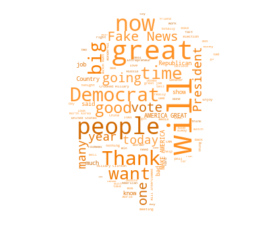

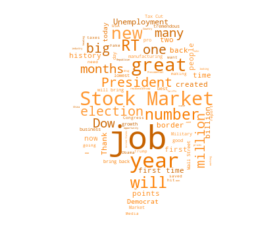

In [210]:
# wordcloud for ALL TWEETS
text = " ".join(tweet for tweet in df['text'][df['text'].str.contains(r'^(?:(?!https|co|amp|realDonaldTrump|Trump).)*$')])

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white",mask=trump_mask, 
                      contour_color ='black',color_func=custom_color).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud_all.png") # save file

# wordcloud for BLOOMBERG tweets

text = " ".join(tweet for tweet in df_bloom['text'][df_bloom['text'].str.contains(r'^(?:(?!https|co|amp).)*$')])

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white",mask=trump_mask_T, 
                      contour_color ='black',color_func=custom_color).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud_bloom.png") # save file

In [211]:
print(df_bloom['sentiment'].describe())

count    383.000000
mean       0.320669
std        0.541008
min       -0.973500
25%        0.000000
50%        0.519800
75%        0.789650
max        0.978800
Name: sentiment, dtype: float64


Filtering the bloomberg data and plotting

In [212]:
df_bloom['outlier'] = abs(df_bloom['firstdifference']) >= df_bloom['firstdifference'].std()*3.5 # get outliers 3.5 times standard deviation

df_bloom_outlier = df_bloom.query('outlier == True')

print('The standard deviation is', round(df_bloom['firstdifference'].std(),2), '\nNumber of observations:',len(df_bloom),'\nOutliers are posted here:')
display(df_bloom_outlier) # display outliers
df_bloom_clean = df_bloom.query('outlier == False') # remove outliers 
print('AFTER OUTLIERS: The standard deviation is', round(df_bloom_clean['firstdifference'].std(),2), '\nAFTER OUTLIERS: Number of observations:',len(df_bloom_clean))

The standard deviation is 277.09 
Number of observations: 383 
Outliers are posted here:


,dow,id,id_int,text,timestamp,firstdifference,relativechange,sentiment,datetime,outlier
datetime,,,,,,,,,,
2018-08-22 20:07:29,25733.5996,1032358618576900096,1032358618576900100,Longest bull run in the history of the stock m...,2018-08-22T20:07:29.000Z,1629.7187,6.333038,0.6360,2018-08-22 20:07:29,True
2018-10-16 13:08:24,25798.4199,1052184484941049857,1052184484941049900,“8X more new manufacturing jobs now than with ...,2018-10-16T13:08:24.000Z,-1124.6094,-4.359218,0.0000,2018-10-16 13:08:24,True
2018-11-26 20:20:59,24640.2402,1067151249668214793,1067151249668214800,"....starts today, election is on December 4th....",2018-11-26T20:20:59.000Z,-1072.1504,-4.351217,0.6239,2018-11-26 20:20:59,True
2018-12-24 15:55:22,21792.1992,1077231267559755776,1077231267559755800,The only problem our economy has is the Fed. T...,2018-12-24T15:55:22.000Z,-2025.2403,-9.293419,0.1007,2018-12-24 15:55:22,True
2018-12-28 12:49:26,23062.4004,1078634025412116480,1078634025412116500,.....close the Southern Border. Bring our car ...,2018-12-28T12:49:26.000Z,1270.2012,5.507671,-0.2062,2018-12-28 12:49:26,True


AFTER OUTLIERS: The standard deviation is 221.34 
AFTER OUTLIERS: Number of observations: 378


**Plotting absolute values (DJIA)**

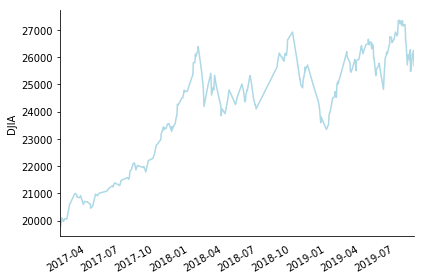

In [213]:
# Plotting figure
fig, ax = plt.subplots()

df_bloom_clean['dow'].plot(ax=ax, color='lightblue')

# Formatting
ax.set_ylabel('DJIA')
ax.xaxis.label.set_visible(False) # remove axis label
ax.spines['right'].set_visible(False) # remove right spine
ax.spines['top'].set_visible(False) # remove top spine
ax.xaxis.set_ticks_position('none') # remove ticks from axis
plt.tight_layout() # prevents cutting off labels
plt.savefig('DJIA.png')

plt.show()

**Plotting first difference (DJIA)**

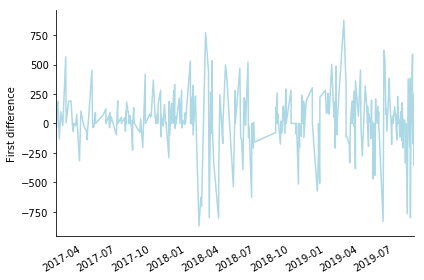

In [214]:
# Plotting figure
fig, ax = plt.subplots()

df_bloom_clean['firstdifference'].plot(ax=ax, color='lightblue')

# Formatting
ax.set_ylabel('First difference')
ax.xaxis.label.set_visible(False) # remove axis label
ax.spines['right'].set_visible(False) # remove right spine
ax.spines['top'].set_visible(False) # remove top spine
ax.xaxis.set_ticks_position('none') # remove ticks from axis
plt.tight_layout() # prevents cutting off labels
plt.savefig('DJIAFD.png')

plt.show()

**Summary data for all tweets and bloomberg selected tweets TOTAL period**

In [215]:
column_id = ['count', 'mean', 'std', 'min', '25%', '50%', '75%' ,'max']
bloom_desc = list(round(df_bloom['sentiment'].describe(), 2))
All_desc = list(round(df['sentiment'].describe(),2))
tabledict = {'All tweets': All_desc, 'Selected tweets': bloom_desc}
tableX =  pd.DataFrame(tabledict, index = column_id).T
display(tableX)
display(tableX.to_latex(index=False))

,count,mean,std,min,25%,50%,75%,max
All tweets,19673.0,0.22,0.55,-0.99,-0.1,0.36,0.70,0.99
Selected tweets,383.0,0.32,0.54,-0.97,0.0,0.52,0.79,0.98


'\\begin{tabular}{rrrrrrrr}\n\\toprule\n   count &  mean &   std &   min &  25\\% &   50\\% &   75\\% &   max \\\\\n\\midrule\n 19673.0 &  0.22 &  0.55 & -0.99 & -0.1 &  0.36 &  0.70 &  0.99 \\\\\n   383.0 &  0.32 &  0.54 & -0.97 &  0.0 &  0.52 &  0.79 &  0.98 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [216]:
date = [i[0]+'-'+i[1][:8] for i in df_bloom['timestamp'].str.split('T')] # slice date
df_bloom['datetime'] = date
df_bloom['datetime'] = pd.to_datetime(df_bloom['datetime'], format='%Y-%m-%d-%H:%M:%S') # format datetime 
df_bloom['datetime']
df_bloom.index = df_bloom['datetime']

**Summary data for all tweets and bloomberg selected tweets by year**

In [217]:
df_bloom_Y = df_bloom['sentiment'].groupby(pd.Grouper(freq='Y'))
display(round(df_bloom_Y.describe(),2))
df_Y = df['sentiment'].groupby(pd.Grouper(freq='Y'))
display(round(df_Y.describe(),2))

,count,mean,std,min,25%,50%,75%,max
datetime,,,,,,,,
2017-12-31,125.0,0.31,0.49,-0.97,0.00,0.42,0.73,0.94
2018-12-31,108.0,0.36,0.53,-0.90,0.00,0.54,0.81,0.98
2019-12-31,150.0,0.30,0.59,-0.97,-0.14,0.54,0.79,0.96


,count,mean,std,min,25%,50%,75%,max
datetime,,,,,,,,
2015-12-31,7536.0,0.26,0.48,-0.97,0.00,0.36,0.67,0.98
2016-12-31,4037.0,0.17,0.54,-0.96,-0.26,0.34,0.62,0.97
2017-12-31,2292.0,0.20,0.58,-0.97,-0.25,0.36,0.72,0.98
2018-12-31,3049.0,0.23,0.63,-0.99,-0.34,0.42,0.80,0.99
2019-12-31,2759.0,0.16,0.63,-0.98,-0.44,0.29,0.74,0.98


**Plotting monthly tweet count - Bloomberg**

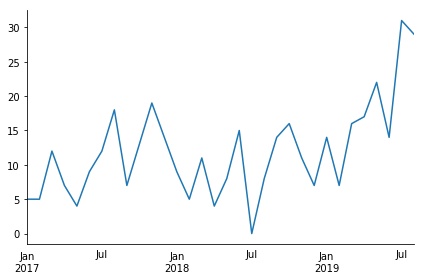

In [218]:
df_bloom['sentiment'].resample('M').count().plot() #secondary_y=True,label='Count',legend=True
ax = plt.gca()
ax.xaxis.label.set_visible(False) # remove axis label
ax.spines['right'].set_visible(False) # remove right spine
ax.spines['top'].set_visible(False) # remove top spine
ax.xaxis.set_ticks_position('none') # remove ticks from axis
plt.tight_layout() # prevents cutting off labels      
plt.savefig('BloombergTweets.png')
plt.show()

**Plotting monthly tweet count - All tweets**

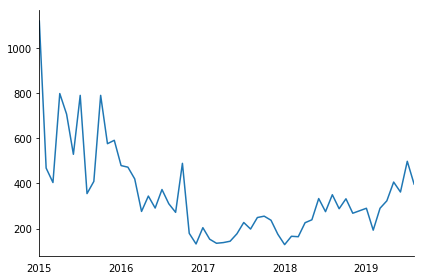

In [219]:

df['sentiment'].resample('M').count().plot() #secondary_y=True,label='Count',legend=True
ax = plt.gca()
ax.xaxis.label.set_visible(False) # remove axis label
ax.spines['right'].set_visible(False) # remove right spine
ax.spines['top'].set_visible(False) # remove top spine
ax.xaxis.set_ticks_position('none') # remove ticks from axis
plt.tight_layout() # prevents cutting off labels      
plt.savefig('AllTweets.png')
plt.show()

In [220]:
df_drop_datetime =df.drop("datetime", axis=1)

### Density plots

Density plot - all tweets

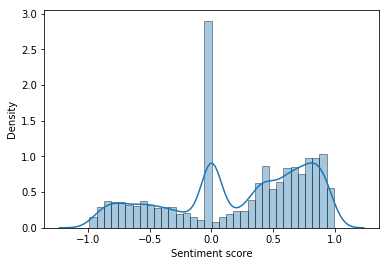

In [221]:
df_sentiment_mean_by_day = df_drop_datetime.groupby('datetime')['sentiment'].mean()
Sentplot = sns.distplot(df_sentiment_mean_by_day, hist=True, kde=True,
             hist_kws={'edgecolor':'black'})
    

Sentplot.set_xlabel('Sentiment score')
Sentplot.set_ylabel('Density')
Sentplot.xaxis.label.set_fontsize(10)
Sentplot.yaxis.label.set_fontsize(10)
FigKDE = Sentplot.get_figure()
FigKDE.savefig('KDEPLOT.png')

Density plot - all tweets without 0.00 sentiment tweets

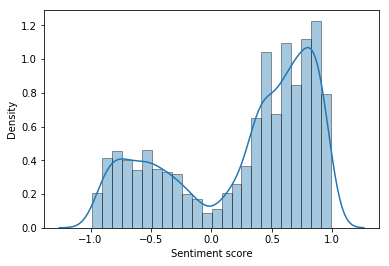

In [222]:
df_drop_null = df_drop_datetime.query('sentiment!=0')
df_null_sentiment_mean_by_day = df_drop_null.groupby('datetime')['sentiment'].mean()
Sentplot = sns.distplot(df_null_sentiment_mean_by_day, hist=True, kde=True,
             hist_kws={'edgecolor':'black'})

Sentplot.set_xlabel('Sentiment score')
Sentplot.set_ylabel('Density')
Sentplot.xaxis.label.set_fontsize(10)
Sentplot.yaxis.label.set_fontsize(10)
FigKDE = Sentplot.get_figure()
FigKDE.savefig('KDEPLOT2.png')

In [223]:
df_bloom_drop_datetime =df_bloom.drop("datetime", axis=1)

Density plots - Bloomberg tweets

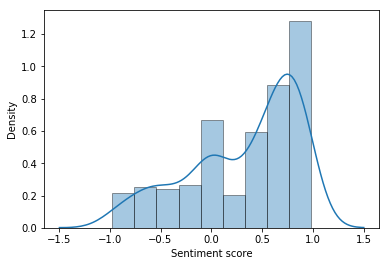

In [224]:
bloom_sentiment_mean_by_day = df_bloom_drop_datetime.groupby('datetime')['sentiment'].mean()
Sentplot = sns.distplot(bloom_sentiment_mean_by_day, hist=True, kde=True,
             hist_kws={'edgecolor':'black'})

Sentplot.set_xlabel('Sentiment score')
Sentplot.set_ylabel('Density')
Sentplot.xaxis.label.set_fontsize(10)
Sentplot.yaxis.label.set_fontsize(10)
FigKDE = Sentplot.get_figure()
FigKDE.savefig('KDEPLOTBLOOM.png')

Density plots - Bloomberg tweets without 0.00 sentiment tweets

By removing tweets with a sentiment score of zero, we have removed 3229 tweets
By removing tweets with a sentiment score of zero, we have removed 40 tweets


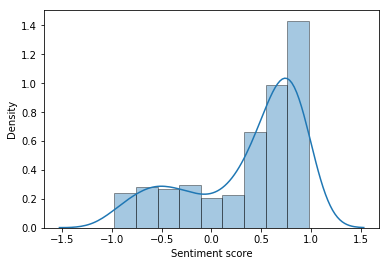

In [225]:
df_bloom_drop_null = df_bloom_drop_datetime.query('sentiment!=0')
bloom_null_sentiment_mean_by_day = df_bloom_drop_null.groupby('datetime')['sentiment'].mean()
Sentplot = sns.distplot(bloom_null_sentiment_mean_by_day, hist=True, kde=True,
             hist_kws={'edgecolor':'black'})

Sentplot.set_xlabel('Sentiment score')
Sentplot.set_ylabel('Density')
Sentplot.xaxis.label.set_fontsize(10)
Sentplot.yaxis.label.set_fontsize(10)
FigKDE = Sentplot.get_figure()
FigKDE.savefig('KDEPLOT2BLOOM.png')

print('By removing tweets with a sentiment score of zero, we have removed', df.shape[0]-df_drop_null.shape[0], 'tweets')
print('By removing tweets with a sentiment score of zero, we have removed', df_bloom.shape[0]-df_bloom_drop_null.shape[0], 'tweets')


### Fuzzy String Matching

To find the relevant tweets we use a fuzzy string matching design by implementing the package Fuzzywuzzy.

In [233]:
def sp500_tickers_names():
    url = 'http://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    resp, call_id = connector.get(url, 'wikilist')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    names = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        name  = row.findAll('td')[1].text
        tickers.append(ticker[:-1]) # removing \n from the ticker ID
        names.append(name)
        
    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(names,f)
        
    return tickers, names

#SP500 = sp500_tickers_names()[1]

keys_500 = sp500_tickers_names()[1]
values_500 =sp500_tickers_names()[0]
sp500_dict = dict(zip(keys_500, values_500))

In [232]:
#Adding names that differ alot from there offical names

missing_names = {'Google':'GOOGL', 'AIG':'AIG', 'JPMorgan':'JPM', 'Microsoft':'MSFT'}
sp500_dict.update(missing_names)

In [234]:
#Running the first fuzzy search 
from fuzzywuzzy import fuzz
#################################################################################
# Warning may take along time (10**7 iterations) - approx 35 min                #
#################################################################################
# Refer instead to the pickled file above
# Second run-through is on reduced firm sample
from tqdm import tqdm
relevant_tweet = {}
store_count = {}
for k,v in tqdm(sp500_dict.items()):
    count_sp = 0
    for i in range(len(df['text'])):
        if fuzz.token_set_ratio(df['text'][i], k)>=60: 
            count_sp +=1
            relevant_tweet[i]=[k,v] 
    store_count[k]=count_sp 

C:\Users\bjorn\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
  0%|▏                                                                                 | 1/505 [00:05<48:01,  5.72s/it]


KeyboardInterrupt: 

In [ ]:
# Inspecting the data frame to see what firms might be problematic
df_sc=pd.Series(store_count)
df_sc = df_sc.to_frame()
df_sc.columns = ['count']
df_sc.query('count >50')

In [ ]:
## Used for second round of fuzzy search:
non_zero_SP500 = list(df_sc.query("count ==0").index) # Select the companies with non-zero amount of relevant tweets
# SP500=non_zero_SP500 #Overwriting the old data frame without the companies with no tweets
all(map(sp500_dict.pop, non_zero_SP500))

**Futher changes to the dataframe:**

The inspection of the data revealed some problematic companies that had to many false positives
AT&T, Energy, Companies, Trade, facebook, resources, general, healthcare, international, Lincoln, national, technology, public, southern,

We try removing parts of company names that have inherent meaning - the idea is to leave the names of the companies\
without the word that has inherent meaning - i.e. to search for Ameriprise rather than Ameriprise Financial
This approach is not without its weaknesses - but right now we are getting to many false positives

In [ ]:
############################## This code was for testing the approach #############################
#Initially we create a list of firms affected by this modification:
# part_remove = []
# for i in range(len(SP500)):
#     if any(j in SP500[i].lower() for j in problematic_names):
#         part_remove.append(SP500[i])

# #We then go over all the firms removing the problematic parts of their names:        
# for part in part_remove:
#       for problems in problematic_names:
#              if problems in part:
#                     part_remove[part_remove.index(part)]=part.replace(problems, '')
##################################################################################################

# Removing the problematic parts 
# AT&T, Energy, Companies, Trade, facebook, resources, general, healthcare, international, Lincoln, national, technology, public, southern,
problematic_names = ['Financial', 'Energy', 'Companies','Corporation', 'Resources', 'National', 'Technology', 'International', 'Company', 'Technologies']
# for firm in SP500:
#       for problems in problematic_names:
#              if problems in firm:
#                     SP500[SP500.index(firm)]=firm.replace(problems, '')    

for key in sp500_dict:
    for problems in problematic_names:
        if problems in key:
            sp500_dict[key.replace(problems, "")] = sp500_dict.pop(key)

sp500_dict
            

We make the fuzzy search again on the data set without the X-irrelevant companies
where we have also removed problematic parts of company names

**Warning may take along time (approx 15 min)** - though it is 237 compared to 509 companies in the first run_through#

Refer instead to the pickled file in the hand-in
Second run-through is on reduced firm sample

In [ ]:
relevant_tweet = {}
store_count = {}
for k,v in tqdm(sp500_dict.items()):
    count_sp = 0
    for i in range(len(df['text'])):
        if fuzz.token_set_ratio(df['text'][i], k)>=60: 
            count_sp +=1
            relevant_tweet[i]=[k,v] 
    store_count[k]=count_sp     

In [ ]:
# Inspecting the data frame to see what firms might be problematic
df_sc=pd.Series(store_count)
df_sc = df_sc.to_frame()
df_sc.columns = ['count']
df_sc.query('count >50')

After this second runthrough we inspect the relevant_tweets and remove directly from here
A more correct approach would be to make changes to the SP500 we search over and do the search again
But due to time-constrain, this very computationally costly approach is unfeasible

Some companies get a huge amount of false positive due to their name being something with inherent meaning

In [ ]:
# After visual inspection of the fuzzy search results, we have added the following exeptions:
exeptions = ['American', 'Anthem', 'America', 'United']

# We create a list so we are able to inspect the amount of tweets we remove, and check companies might be affected
# remove_ex = {}
# for i, j in relevant_tweet.items():
#         if any(ex in relevant_tweet[i].lower() for ex in exeptions):
#             remove_ex[i]=j
remove_ex = {}
for i, j in relevant_tweet.items():
        if any(ex in j[0] for ex in exeptions):
            remove_ex[i]=j[0]
#display(remove_ex[0:100]) -> removed firms like: united, packaging of america, American express, american airlines.
#Then we remove these tweets from the relevant_tweets using the pop function
all(map( relevant_tweet.pop, remove_ex))

After removing the exceptions we inspect the relevant_tweets again, and find an amount of tweets on AT&T that indicates problems

In [ ]:
#looking at AT&T
ATT_tweets=[k for k,v in relevant_tweet.items() if v[0] == 'AT&T Inc.']
att_tweets = []
#Inserting tweet ID in df['text'] to call tweets
for i in ATT_tweets:
    att_tweets.append(df['text'][i])
    
display(att_tweets[0:5]) # Reading over contents
# We discover the following issue:
print(fuzz.token_set_ratio('Today, I was thrilled to host the @WWP Soldier Ride once again at the @WhiteHouse. We were all deeply honored to be in the presence of TRUE AMERICAN HEROES....https://t.co/q6D5875xCw', 'AT&T'))
print(fuzz.token_set_ratio('at', 'AT&T'))
#Removing AT&T tweets - since every tweet with the word 'at' will get 100 pct. match
print(len(relevant_tweet)) #Checking length before removing
print(len(ATT_tweets)) # Amount to be removed
all(map(relevant_tweet.pop, ATT_tweets)) #Removing using the pop function over the dict relevant_tweet
print(len(relevant_tweet)) # Check if result adds up


We reuse the approach used on AT&T on the following

In [ ]:
# Third inspection indicates we scould inspect the following companies: 
problem_comp = ['Dollar General', 'E*Trade', 'Fox  Class A', 'General Dynamics', 'General Electric',\
                'General Mills', 'General Motors','HCA Healthcare', 'Southern Co.', 'Chubb Limited', 'CVS Health', 'Juniper Networks']
problem_tweets = {}
problem_list = {}
for comp in problem_comp:
    problem_list[comp] = [k for k,v in relevant_tweet.items() if v[0] == str(comp)]
    problem_tweets[comp] = [df['text'][k] for k,v in relevant_tweet.items() if v[0] == str(comp)]

# This step requires manually inputting the firm-key for inspection since the full amount of tweets at once
# are too much to show/consider at once. 
problem_tweets['General Motors']

#problem_list[1]

# Below are the conclusions regarding the relevance of the individual firm
# Manually looking through reveals:
# 
#Dollar General	Irrelevant
#E*Trade	Irrelevant
#Fox Class A	Relevant (considering fox news is part of Fox Class A)
#General Dynamics	Irrelevant
#General Electric	Irrelevant
#General Mills	Irrelevant
#General Motors	 Partially relevant
#HCA Healthcare	Irrelevant
#Southern Co.	Irrelevant
#Chubb Limited 	Irrelevant
#CVS Health 	 Irrelevant
#Juniper Networks 	 Irrelevant

In [235]:
# Based on the conclusions above we remove the following firms:
tweets_to_remove = []
irrelevant_comps = ['E*Trade', 'General Electric','HCA Healthcare', 'Southern Co.', 'Chubb Limited', 'CVS Health', 'Juniper Networks']
for comp in irrelevant_comps:
     for k,v in problem_list.items():
            if k==comp:
                tweets_to_remove.append(v)


for i in range(len(tweets_to_remove)):
     all(map(relevant_tweet.pop, tweets_to_remove[i]))

NameError: name 'problem_list' is not defined

In [ ]:
#Inspecting the relevant_tweet frame
df_rele=pd.Series(relevant_tweet)
df_rele = df_rele.to_frame()
df_rele.columns = ['Company']
df_rele.head(10)

# We checking the reduced relevant_tweet frame for how many times the unique companies are mentioned:
store_counts_rele = {}
company_unique = []
for k, v in relevant_tweet.items():
    company_unique.append(v[0])


for i in set(company_unique):
    count = 0
    for j in df_rele.index:
        if df_rele['Company'][j][0]==str(i):
            count+=1
    store_counts_rele[i]=count

store_counts_rele

Inspection of these results indicate that the following companies produce to many false positives:
Unum Group, Public Storage, Dollar, Best Buy Co. Inc, Robert Half, Paper, Dish Network, The Bank of New York mellon Corp, lam Research, ball C
General Motors - we still haven't solved that theese were partially relevant (10%)

In [ ]:
# Fourth round of inspection indicates we should inspect the following companies: 
problem_comp4 = ['Unum Group', 'Public Storage', 'Dollar Tree', 'Best Buy Co. Inc.',\
                'Robert Half ','AvalonBay Communities, Inc.',\
                ' Paper','Waters ', 'Dish Network', 'The Bank of New York Mellon Corp.','Lam Research', 'Ball Corp']
problem_tweets4 = {}
problem_list4 = {}
for comp in problem_comp4:
    problem_list4[comp] = [k for k,v in relevant_tweet.items() if v[0] == str(comp)]
    problem_tweets4[comp] = [df['text'][k] for k,v in relevant_tweet.items() if v[0] == str(comp)]
    
problem_tweets4['Ball Corp']
#problem_list4

# Manually looking through reveals:
# Conclusions:
#Unum Group	Irrelevant (only group)
#Public Storage	Irrelevant (Only public)
#Dollar Tree	Irrelevant ( only dollar)
#Best Buy Co. Inc.	Irrelevant (only best or buy)
#Robert Half 	Irrelevant (Robert Mueller tweets)
#AvalonBay Communities, Inc.	Irrelevant (only communities)
#Paper	 Irrelevant (about newspapers)
#Waters	Irrelevant
#Dish Network.	Irrelevant (only network)
#The Bank of New York Mellon Corp. 	Irrelevant (only bank and new york)
#Lam Research 	 Irrelevant (only research)
#Ball Corp 	 Irrelevant

In [ ]:
#We remove tweets according to the conclusion to the search above
tweets_to_remove4 = []
irrelevant_comps4 = ['Unum Group', 'Public Storage', 'Dollar Tree', 'Best Buy Co. Inc.',\
                'Robert Half ','AvalonBay Communities, Inc.',\
                ' Paper','Waters ', 'Dish Network', 'The Bank of New York Mellon Corp.','Lam Research', 'Ball Corp']
for comp in irrelevant_comps4:
     for k,v in problem_list4.items():
            if k==comp:
                tweets_to_remove4.append(v)

for i in range(len(tweets_to_remove4)):
      all(map(relevant_tweet.pop, tweets_to_remove4[i]))
    

Last thing we fix is the General Motors problem where we found some tweets we relevant,
and we were reluctant to remove them all
Trying to identify the relevant general motors tweets 

In [ ]:
problem_gen_id_tweet = {}
for k,v in relevant_tweet.items():
    if v[0] == 'General Motors':
        problem_gen_id_tweet[k]=df['text'][k]

# After manuel inspection we have determined the following keywords to avoid irrelevant tweets

keywords = ['Barra', '@GM', 'Motors', 'G.M.']
save_gen = []    
for k, v in problem_gen_id_tweet.items():
          if any(key in v for key in keywords):
              save_gen.append(k)
            
all(map(problem_gen_id_tweet.pop, save_gen)) #Removing the relevant tweets from our problem_GM_tweets
all(map(relevant_tweet.pop, problem_gen_id_tweet)) #Removing the irrelevant tweets

In [ ]:
# We pickle the resulting dictionary as not to require anyone to run the fuzzysearch
pickle.dump(relevant_tweet, open( "Final_tweet_with_tickers.p", "wb" ) ) 

In [ ]:
tweets_final_GMfix = {}
for k,v in relevant_tweet.items():
    tweets_final_GMfix[df['text'][k]] = v

# We pickle the tweets aswell    
pickle.dump(tweets_final_GMfix, open( "tweets_final_with_tickers.p", "wb" ) ) 

In [ ]:
relevant_tweet_load = pickle.load( open( "Final_tweet_GMfix.p", "rb" ) )
tweets_final_GMfix_load = pickle.load(open("tweets_final_GMfix.p", "rb"))
print(relevant_tweet_load == relevant_tweet) #sanity check
print(tweets_final_GMfix_load == tweets_final_GMfix) #sanity check

In [ ]:
get_index_comp = []
get_index_time = []
get_index_ticker = []
for k,v in relevant_tweet.items():
    get_index_comp.append(v[0])
    get_index_ticker.append(v[1])
    get_index_time.append(df.index[k])

Finally, we collect it into a data frame. 

In [ ]:
d_relevant = {'Timestamp': get_index_time, 'Company':get_index_comp, 'Ticker': get_index_ticker}
df_relevant = pd.DataFrame(d_relevant)
df_relevant.head()

In [ ]:
pickle.dump(df_relevant, open( "df_relevant.p", "wb" ) ) # saving data frame to a pickle file 

### Machine Learning

In this part we use machine learning to perform regression and classification analysis. Due to time constraint we did not wrap them in a function and to avoid duplicate code we only show the results of the machine learning model based on one data frame. The PDF contains the results of all data frames.

Data frame: Fuzzyword filtered

In [243]:
df_fuzzy = pickle.load( open( "df_complete_final.p", "rb" ) )
print(type(df_fuzzy['1. open'][1]))

<class 'numpy.float64'>


Data frame: Bloomberg

In [228]:
# Preparing bloomberg tweet data frame
df_stock = AlphaVantage(data_dji) # data_dji returns dow jones data, data_sp returns s&p 500 data
df_bloom_clean = df_bloom.copy()
df_bloom_clean.reset_index(drop=True)
df_bloom_clean['time'] =  range(0,df_bloom_clean['datetime'].count())
df_bloom_clean['datetime'] = df_bloom_clean['datetime'].dt.date # format datetime
df_bloom_clean = df_bloom_clean.set_index('datetime',drop=True)
df_bloom_clean = df_bloom_clean.dropna()
df_merge = pd.merge(df_stock, df_bloom_clean, left_index=True, right_index=True)
features =  ['time','sentiment','volume','open']
display(df_merge.head())

KeyError: 'Time Series (Daily)'

Dataframe: All tweets

In [ ]:
# DATA ALL TWEETS - COMPARING TO S&P500
df_all = df.copy()
df_stock = AlphaVantage(data_sp)
for i in df_stock.columns:
    df_stock[i] = df_stock[i].astype(float)
df_all['datetime'] = df_all['datetime'].dt.date # format datetime
df_all = df_all.set_index(df_all['datetime'],drop=True)
df_merge = pd.merge(df_all, df_stock, left_index=True, right_index=True)
df_merge['time'] =  range(0,df_merge['datetime'].count())
features = ['time','sentiment','volume','open']
display(df_merge[features].head())    

**Time series split**

In [ ]:
# X variables

X1 = df_merge[features].values # features
X = sm.add_constant(X1)
splits = TimeSeriesSplit(n_splits=5)

for train_index, test_index in splits.split(X):
    X_train = X[train_index]
    X_test = X[test_index]
#pyplot.show()

# Y variable
Y = df_merge['pct_change'].values # target variable
splits = TimeSeriesSplit(n_splits=5) # number of splits
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(Y):
    y_train = Y[train_index]
    y_test = Y[test_index]
#     print('Observations: %d' % (len(y_train) + len(y_test)))
#     print('Training Observations: %d' % (len(y_train)))
#     print('Testing Observations: %d' % (len(y_test)))
    pyplot.subplot(510 + index)
    pyplot.plot(y_train)
    pyplot.plot([None for i in y_train] + [x for x in y_test])
    index += 1
pyplot.show()

**Linear Regression model**

In [ ]:
linreg=linear_model.LinearRegression()
linreg.fit(X_train, y_train)
linreg.coef_
a=linreg.predict(X_test)

# Print RMSE
print('RMSE:',round(sqrt(np.mean((a-y_test)**2)),3))
# Print R^2
print('R-squared:',round(sklearn.metrics.r2_score(y_test, a)),3)

Conducting OLS regression and printing results

In [ ]:
# Linear regression: Fitting model and printing results
Y = df_merge['pct_change'].values
ols = sm.OLS(Y, X)
ols_results = ols.fit()
res = ols_results.summary()
res.as_latex() # print to latex format
print(res)

**CREATING PIPELINES**

In [ ]:
pipe_preproc = make_pipeline(PolynomialFeatures(), StandardScaler())

# Fitting and transforming data 
pipe_preproc.fit(X_train)
X_train_prep = pipe_preproc.transform(X_train)
X_test_prep = pipe_preproc.transform(X_test)


**Pipeline for linear regression**

In [ ]:
#PIPELINE LINEAR REGRESSION
pipe_lr = make_pipeline(PolynomialFeatures(degree=3,include_bias=False), 
                        StandardScaler(),
                        LinearRegression()
                       )

pipe_lr.fit(X_train, y_train)

**Pipeline for LASSO**

In [ ]:
#PIPELINE LASSO
lassolist = []
lambdas = np.logspace(-4, 4, 33) # Defining the lambda space wherein to test
# Testing different hyperparameter
for lambda_ in lambdas:
    pipe_lasso = make_pipeline(PolynomialFeatures(degree=3,include_bias=False), 
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=1)
                              )
    pipe_lasso.fit(X_train, y_train)
    y_pred = pipe_lasso.predict(X_train)
    mse_lasso = mse(y_pred, y_train)
    lassolist.append(sqrt(mse_lasso))

# Selecting the optimal hyperparameter
hyperparam_lasso = pd.Series(lassolist,index=lambdas)
optimal_lasso = hyperparam_lasso.nsmallest(1)    

# Updating pipeline with optimal parameter
pipe_lasso = make_pipeline(PolynomialFeatures(degree=3,include_bias=False), 
                               StandardScaler(),
                               Lasso(alpha=optimal_lasso.index[0]))
pipe_lasso.fit(X_train,y_train)

# Print optimal hyperparameter
print('Optimal hyperparameter (lambda) value for LASSO:', optimal_lasso)

In [ ]:
# LASSO: Fitting the model and printing coefficients
LASSO = linear_model.Lasso(alpha=optimal_lasso.index[0])
LASSO.fit(X_train, y_train)
LASSO.coef_

**Pipeline for Ridge**

In [ ]:
#PIPELINE RIDGE
ridgelist = []
lambdas = np.logspace(-4, 4, 33) # Defining the lambda space wherein to test
# Testing different hyperparameter
for lambda_ in lambdas:
    pipe_ridge = make_pipeline(PolynomialFeatures(degree=3,include_bias=False), 
                               StandardScaler(),
                               Ridge(alpha=lambda_, random_state=1)
                              )
    pipe_ridge.fit(X_train, y_train)
    y_pred = pipe_ridge.predict(X_train)
    mse_ridge = mse(y_pred, y_train)
    ridgelist.append(sqrt(mse_ridge))

# Selecting the optimal hyperparameter
hyperparam_ridge = pd.Series(ridgelist,index=lambdas)
optimal_ridge = hyperparam_ridge.nsmallest(1)

# Updating pipeline with optimal parameter
pipe_ridge = make_pipeline(PolynomialFeatures(degree=3,include_bias=False), 
                               StandardScaler(),
                               Ridge(alpha=optimal_ridge.index[0]))
pipe_ridge.fit(X_train,y_train)

# Print optimal hyperparameter
print('Optimal hyperparameter (lambda) value for Ridge:', optimal_ridge)

In [ ]:
# Ridge: Fitting the model and printing coefficients
ridge = linear_model.Ridge(alpha=optimal_ridge.index[0])
ridge.fit(X_train, y_train)
ridge.coef_

**Print RMSE for each regularization**

In [ ]:
# Printing the RMSE: root mean squared error
print('Linear Regression', round(sqrt(mse(pipe_lr.predict(X_test),y_test)), 3))
print('Ridge', round(sqrt(mse(pipe_ridge.predict(X_test),y_test)), 3))
print('Lasso', round(sqrt(mse(pipe_lasso.predict(X_test),y_test)), 3))
# Dictionary 
pipe_dict = {'pipe_lr':sqrt(mse(pipe_lr.predict(X_test),y_test))
            , 'pipe_ridge':sqrt(mse(pipe_ridge.predict(X_test),y_test))
            , 'pipe_lasso':sqrt(mse(pipe_lasso.predict(X_test),y_test))
            }
print('Smallest RMSE obtained using', min(pipe_dict, key=pipe_dict.get))

Choosing LASSO as the preferred choice. Next, we construct the learning curve.

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lasso,
                   X=X_train,
                   y=y_train,
                   train_sizes=np.linspace(0.1, 1.0, 10),
                   scoring='neg_mean_squared_error',                 
                   cv=5)

mse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))    

**Plotting the learning curve**

In [ ]:
f_learn, ax = plt.subplots(figsize=(10,4))
mse_.plot(ax=ax, logy=True)

# Plotting 95% confidence band
ax.fill_between(train_sizes,
                -train_scores.mean(1) + train_scores.std(1)*1.96,
                -train_scores.mean(1) - train_scores.std(1)*1.96, 
                alpha=0.1, 
                color='green')
ax.set_ylabel('Mean squared error')

f_learn.savefig("LearningCurve.png")

### Classification

Splitting while not disrupting the chronological order.

In [ ]:
X = df_merge[features].values
splits = TimeSeriesSplit(n_splits=10)
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(X):
    X_train = X[train_index]
    X_test = X[test_index]

Y = df_merge['bool'].values
splits = TimeSeriesSplit(n_splits=10)
# pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(Y):
    y_train = Y[train_index]
    y_test = Y[test_index]
#     print('Observations: %d' % (len(y_train) + len(y_test)))
#     print('Training Observations: %d' % (len(y_train)))
#     print('Testing Observations: %d' % (len(y_test)))
#     pyplot.subplot(510 + index)
#     pyplot.plot(y_train)
#     pyplot.plot([None for i in y_train] + [x for x in y_test])
#     index += 1
# plt.show()
# plt.savefig('Classification.png')

    

In [ ]:
#Classification tree: k-fold cross validation
kfolds = TimeSeriesSplit(n_splits=10)
est = np.unique(np.logspace(0,2,20).astype(np.int64))
acc_tot=[]
for n in est:

    ran_clf=DecisionTreeClassifier(random_state=1)  
    accuracy_ = []

    for train_i, validation_i in kfolds.split(X_train, y_train):

        X_train, y_train, = X_train, y_train
        X_val, y_val = X_test, y_test 

        ran_clf.fit(X_train, y_train)

        y_hat = ran_clf.predict(X_val)

        accuracy_.append((accuracy_score(y_val, y_hat, normalize=True, sample_weight=None)))

    acc_tot.append(accuracy_)

# Calculating the mean of the MSE from the splits    
meanACC_tot= pd.DataFrame(acc_tot, index=est).mean(axis=1)
optimalACC_tot=meanACC_tot.nsmallest(1)
print('Prediction accuracy:', round(optimalACC_tot[1],4))
print('Share of observations where the daily change is positive:', 
      round(df_merge['bool'].sum()/df_merge['bool'].count(),4))

### LOG FILE

Visualizing our log file. 

In [ ]:
import datetime
log_df = pd.read_csv('my_log.csv',sep=';') # loading the log, separated by ";"
log_df = log_df[0:10].copy()
display(log_df)
#dt = log_df.dt.values[0] # get datetime values

log_df['dt'] = log_df.t.apply(datetime.datetime.fromtimestamp)
log_df['dt'] = pd.to_datetime(log_df.t,unit='s') # Convert the time column 't' to datetime 

plt.figure(figsize=(15,4))
plt.plot(log_df.dt,log_df.delta_t)
plt.ylabel('Delta t')
plt.xlabel('Scraping progress')
plt.savefig('LogGraphTime.png')

# Plot the response size over time.
plt.figure(figsize=(15,4))
plt.ylabel('Size of response')
plt.xlabel('Scraping progress')
plt.plot(log_df.dt,log_df.response_size)

## Investigate errors
log_df.success.value_counts() ## Count errors
## Groupby time
# round the time for aggregation
log_df['dt_minute'] = log_df.dt.apply(lambda x: x-datetime.timedelta(seconds=x.second,microseconds=x.microsecond))
#log_df['dt_hour'] = log_df.dt.apply(lambda x: x-datetime.timedelta(minutes=x.minute,seconds=x.second,microseconds=x.microsecond))
#log_df.groupby('dt_hour').success.mean()
plt.savefig('LogGraph.png')

THE END